# Histopathologic Cancer Detection Competition Submission
Link to Kaggle Project: https://www.kaggle.com/c/histopathologic-cancer-detection/overview

Link to GitHub Repo: https://github.com/b5050d/5642_Week_3.git

### Problem Description

In this Kaggle Competition, the challenge is to analyze a set of 32x32 pixel images of medical scan imagery and predict whether the image patch contains any cancerous cells. The images are given as 96x96 pixels and the region in which the cancerous cells are analyzed to be present or not are located in the central 32x32 region of the image.



### Data Description

This data is made up of a lot of images. As mentioned before the size of each image is 96x96 pixels, with 3 color values per pixel. 

The training data is made up of 220025 images.
The testing data is made up of 57458 images.

For each image in the training set, there is an associated label of 0 for no cancer present, or 1 for cancer is detected.

In [123]:
# Lets start by handling our imports for the project first
import os
import random
from pathlib import Path
import time

import numpy as np
import pandas as pd
import tensorflow as tf
import tifffile as tiff
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

# Set up the Local Paths, when this is on Kaggle, the paths should be different if you want to run on there
data_path = "C:\\Users\\Ben\\Workspace\\mscs\\5642\\week3\\data_to_gitignore"
test_folder = Path(f"{data_path}\\test")
train_folder = Path(f"{data_path}\\train")
sample_submission = Path(f"{data_path}\\sample_submission.csv")
train_labels = Path(f"{data_path}\\train_labels.csv")

## Exploratory Data Analysis

### Inspect and Visualize the Data

Lets start by looking at the training labels file and take a look at the format and distribution:

Training Labels:
Shape: (220025, 2)
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


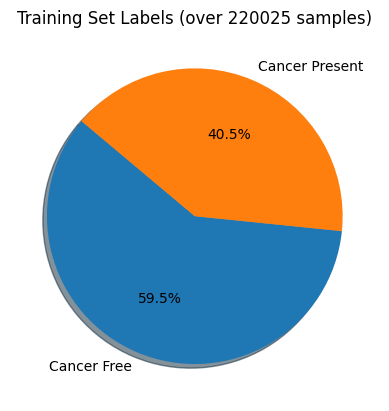

In [124]:
# Look at the training Labels data set
train_labels_df = pd.read_csv(train_labels)
print("Training Labels:")
print(f"Shape: {train_labels_df.shape}")
print(train_labels_df.head())

#Ok and what is the distribution of our data, how many have cancer and how many dont?
values = train_labels_df["label"].unique().tolist()
amounts = []
tags = []
for v in values:
    amounts.append((train_labels_df['label'] == v).sum())
    if int(v) == 0:
        tags.append("Cancer Free")
    else:
        tags.append("Cancer Present")

# Visualize using a pie chart
plt.pie(
    amounts,
    labels=tags,
    autopct='%1.1f%%',
    startangle=140,
    shadow=True
    )
plt.title(f"Training Set Labels (over {len(train_labels_df)} samples)")
plt.show()

Ok, we can see that the training labels file contains just the name of the image file as 'id' and 'label' for the cancerous/cancer-free classification. We can also see that this is a good split in the data. We have enough of each class to effectively train our model and the balance does not need to be adjusted to train. In addition, during this plot we have uncovered that there are no missing labels for any of the data and therefore we can skip that step of cleaning.

Lets start by taking a look at:
- how large our image sets are
- how many pixels are in the images
- what depth are the pixels
- what are the range of values present in the images

Number of training images: 220025
Number of testing images: 57458

<class 'numpy.ndarray'>
Size of Image in the Dataset: (96, 96, 3)


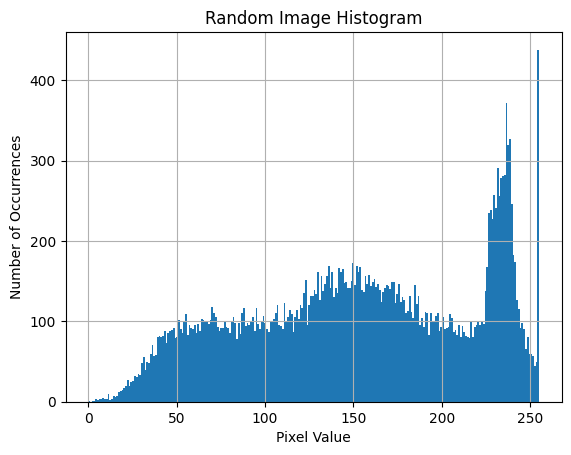

In [ ]:
# Find the filepaths of all of the training images and test images
training_images = list(train_folder.glob("*.tif"))
testing_images = list(test_folder.glob("*.tif"))

print(f"Number of training images: {len(training_images)}")
print(f"Number of testing images: {len(testing_images)}")
print("")

# Take a random image
random_image_path = training_images[4321]

# Load the random image
random_image = tiff.imread(random_image_path)

print(type(random_image))
print("Size of Image in the Dataset: {}".format(random_image.shape))

flat_image = random_image.flatten()

plt.grid()
plt.hist(flat_image, bins = 256)
plt.title("Random Image Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Number of Occurrences")
plt.show()

Ok, so there are 220025 images in our training set which matches the training labels (thats good!)
And there are 57458 images that we need to make predictions for

We also can see that the images are of size: [96,96,3] and that each pixel is valued between 0 and 255.

Ok so what do the images actually look like?

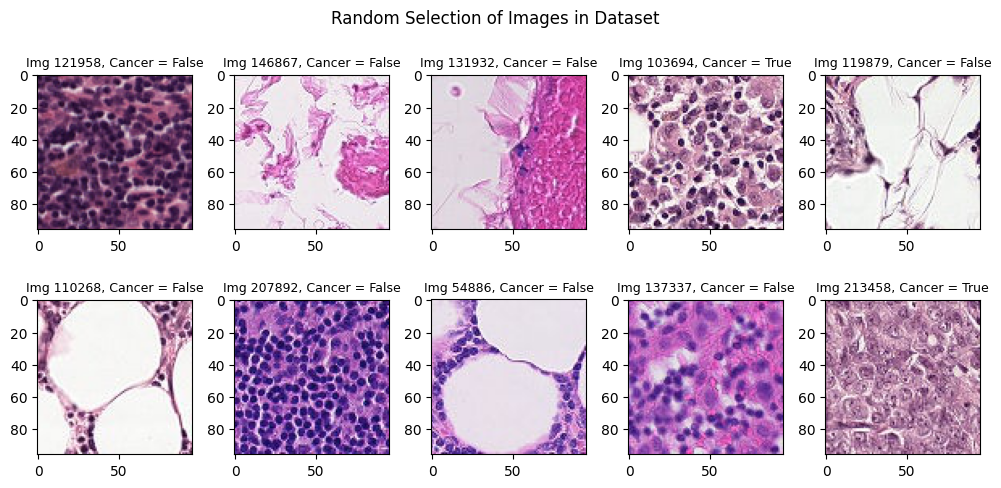

In [4]:
# Ok and what do some images look like?
# get a sample of images of length 10
np.random.seed(42)

randys = []
for i in range(10):
    randys.append(np.random.randint(0,len(training_images)))

#Alright now we need to display these images
fig, axes = plt.subplots(2,5, figsize=(10,5))

axes = axes.flatten()

for i, ax in enumerate(axes):
    randint = randys[i]
    image_path = training_images[randint]
    image_name = Path(image_path).stem
    image_mat = tiff.imread(image_path)
    ax.imshow(image_mat)
    has_cancer = bool(train_labels_df.loc[train_labels_df['id'] == image_name, 'label'].values[0])
    ax.set_title(f"Img {randys[i]}, Cancer = {has_cancer}", fontsize=9)

fig.suptitle("Random Selection of Images in Dataset")
plt.tight_layout()
plt.show()

### Clean the Data

We already know that there are no missing labels so that is good. 

Next we need to set up the data to be organized and able to be efficiently loaded into our models. Since images are so large and there are so many of them, it does not make sense to load them all into RAM. In order to do this, we can use Data Generators provided by the Keras Library.

Lets start by making a small subset of data to use to iterate the design of our model and we can use the full data later.

In [137]:
# Build the data generator

# Alright well lets start by using the full dataset
train_df = train_labels_df.copy()

def add_file_extension(x):
    return data_path + "\\train\\" + x + ".tif"

# Modify the ID column to have the full filepaths
train_df["filepath"] = train_df["id"].apply(add_file_extension)

# Modify the Labels to be all strings (because thats
# what the datagenerator wants)
train_df["label"] = train_df["label"].apply(str)

# Lets take a small subset of our data to train our experiments on to save time
subset_df = train_df.sample(frac=0.05, random_state=42)
X = subset_df.drop(columns = ["id", "label"])
y = subset_df.drop(columns = ["id", "filepath"])

# Create the Train Test split on our subset for training and validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .2, random_state=42)

# Reformat into dataframes for the generators
train_data_df = X_train.copy()
train_data_df["label"] = y_train["label"]

test_data_df = X_test.copy()
test_data_df["label"] = y_test["label"]

# Start the Image Data Generators to load files fast
# # Scale all values to 1
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    dataframe = train_data_df,
    x_col = 'filepath',
    y_col = 'label',
    target_size = (96,96),
    batch_size = 32,
    class_mode = 'binary',
)
test_generator = datagen.flow_from_dataframe(
    dataframe = test_data_df,
    x_col = 'filepath',
    y_col = 'label',
    target_size = (96,96),
    batch_size = 32,
    class_mode = 'binary',
)

Found 8800 validated image filenames belonging to 2 classes.
Found 2201 validated image filenames belonging to 2 classes.


### Plan of Analysis

Based on the EDA procedure taken, the plan for analysis of which model to use is the following:
- Build an MVP (Minimum Viable Product)
- Conduct a Series of Experiments on Model Architecture and Hyperparameters to choose a Final Model
- Train and Test the Final Model

## Model Architecture

Before we can select a final model, its important to understand how architecture design decisions impact model performance on this data set. In the interest of this, lets start by creating an MVP (minimal viable product) to start from and then we will run a series of experiments to determine the best architecture decisions to use to build our model.

In [ ]:
# Build the MVP
mvp_model = Sequential()

mvp_model.add(Conv2D(32, (3,3), activation = 'relu', input_shape=(96,96,3)))
mvp_model.add(MaxPooling2D(pool_size=(2,2)))

mvp_model.add(Flatten())
mvp_model.add(Dense(128, activation='relu'))
mvp_model.add(Dense(1, activation='sigmoid')) 

custom_optimizer = Adam(
    learning_rate = .001,
)
mvp_model.compile(optimizer = custom_optimizer,
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy'])

mvp_model.summary()

Model: "sequential_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_196 (Conv2D)         (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_246 (MaxPooli  (None, 47, 47, 32)       0         
 ng2D)                                                           
                                                                 
 flatten_87 (Flatten)        (None, 70688)             0         
                                                                 
 dense_174 (Dense)           (None, 128)               9048192   
                                                                 
 dense_175 (Dense)           (None, 1)                 129       
                                                                 
Total params: 9,049,217
Trainable params: 9,049,217
Non-trainable params: 0
___________________________________________

In [127]:
print("Fitting the MVP")

history = mvp_model.fit(
    train_generator,
    epochs = 10,
    validation_data = test_generator)

Fitting the MVP
Epoch 1/10
275/275 [==============================] - 29s 103ms/step - loss: 0.6682 - accuracy: 0.7193 - val_loss: 0.5066 - val_accuracy: 0.7651
Epoch 2/10
275/275 [==============================] - 28s 101ms/step - loss: 0.4728 - accuracy: 0.7743 - val_loss: 0.4751 - val_accuracy: 0.7692
Epoch 3/10
275/275 [==============================] - 27s 98ms/step - loss: 0.4214 - accuracy: 0.8168 - val_loss: 0.4942 - val_accuracy: 0.7824
Epoch 4/10
275/275 [==============================] - 27s 98ms/step - loss: 0.3629 - accuracy: 0.8418 - val_loss: 0.5581 - val_accuracy: 0.7474
Epoch 5/10
275/275 [==============================] - 28s 100ms/step - loss: 0.2975 - accuracy: 0.8782 - val_loss: 0.5149 - val_accuracy: 0.7769
Epoch 6/10
275/275 [==============================] - 27s 98ms/step - loss: 0.2109 - accuracy: 0.9233 - val_loss: 0.5862 - val_accuracy: 0.7619
Epoch 7/10
275/275 [==============================] - 27s 100ms/step - loss: 0.1516 - accuracy: 0.9498 - val_loss: 0.

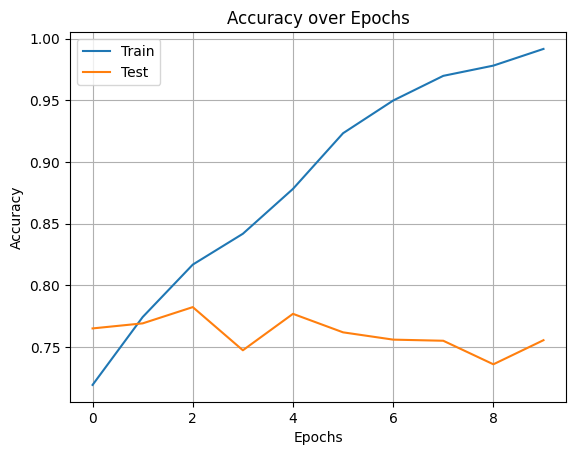

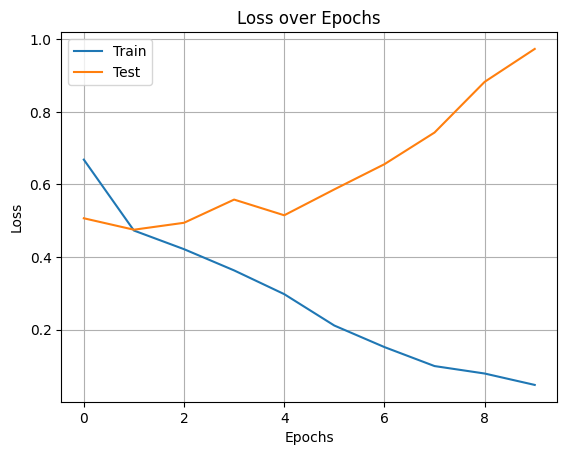

In [128]:
plt.plot(history.epoch, history.history["accuracy"])
plt.plot(history.epoch, history.history["val_accuracy"])
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Test"])
# plt.ylim((0,1))
plt.grid()
plt.show()

plt.plot(history.epoch, history.history["loss"])
plt.plot(history.epoch, history.history["val_loss"])
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Test"])
# plt.ylim((0,(maxy)))
plt.grid()
plt.show()

Alright so we have proved we can actually train our model. We can see that the model we selected is not very good. It is clearly overfitting which can be observed in the Loss over Epochs figure.

## Setting Up Experiments

In order to select the architecture and parameters for a well performing model, lets run some experiments to get a better understanding of how these models work and what levers we have to tune.

Before we get started, lets create some methods that will assist us in creating these experiments and evaluating the results

In [129]:
# Lets Build a Timer
class Timer:
    """
    Simple Timer to help us analyze the efficiency of our models
    """
    
    def __init__(self):
        """
        Set up the class
        """
        self.start_time = 0
        self.end_time = 0

    def start(self):
        """
        Start the timer
        """
        self.start_time = time.time()
        print("Started Timer")

    def stop(self):
        """
        Stop the timer
        """
        self.stop_time = time.time()
        print("Stopped Timer")

    def get_time(self):
        """
        Get the timer on the clock (an integer value of seconds)
        """
        ans = self.stop_time - self.start_time
        ans = int(ans)
        print("Time on the clock : {}".format(ans))
        return ans

In [130]:
def perform_experiment(experiment_models, train_generator, test_generator, num_epochs):
    """
    Perform an Experiment by training the models
    and extracting some important information
    """
    exp_histories = []
    exp_times = []

    for model in experiment_models:
        my_timer = Timer()
        my_timer.start()

        history = model.fit(
            train_generator,
            epochs = num_epochs,
            validation_data = test_generator,
        )
        exp_histories.append(history)

        my_timer.stop()
        time_taken = my_timer.get_time()

        exp_times.append(time_taken)
    
    return exp_histories, exp_times

In [131]:
def perform_basic_plots(exp_num, histories, times):
    """
    Perform some basic plotting that will be useful for
    each experiment
    """
    exps = [i for i in range(len(times))]
    legend = [f"Model{e}" for e in exps]

    # Plot the Accuracy
    for h in histories:
        plt.plot(h.epoch, h.history["val_accuracy"])
    plt.title(f"Experiment {exp_num} Validation Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(legend)
    plt.grid()
    plt.show()

    # Plot the Loss
    for h in histories:
        plt.plot(h.epoch, h.history["val_loss"])
    plt.title(f"Experiment {exp_num} Validation Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(legend)
    plt.grid()
    plt.show()

    # Plot the times taken to train each model
    plt.bar(exps, times)
    plt.title(f"Experiment {exp_num} Model Fitting times")
    plt.xlabel("Model")
    plt.ylabel("Training Time [s]")

    plt.show()

## Experiment 1: Changing # of Conv2D + MaxPool Layers

The first experiment to conduct is to use a different amount of [Conv2D, MaxPool] pairs. Lets start with 1, and then add up to 5 of these layers and see how performance on the validation data changes 

In [132]:
# Build the Experiment 1 Models
exp_1_n = 5

experiment_1_models = []

for i in range(exp_1_n):
    new_model = Sequential()
    new_model.add(Conv2D(32, (3,3), activation = 'relu', input_shape=(96,96,3)))
    new_model.add(MaxPooling2D(pool_size=(2,2)))

    for j in range(i):
        new_model.add(Conv2D(32, (3,3), activation = 'relu'))
        new_model.add(MaxPooling2D(pool_size=(2,2)))

    new_model.add(Flatten())
    new_model.add(Dense(128, activation='relu'))
    new_model.add(Dense(1, activation='sigmoid')) 

    custom_optimizer = Adam(
        learning_rate = .001,
    )
    
    new_model.compile(optimizer = custom_optimizer,
                    loss = 'binary_crossentropy',
                    metrics = ['accuracy'])

    experiment_1_models.append(new_model)

print(experiment_1_models)

[<keras.engine.sequential.Sequential object at 0x0000026FD05652E0>, <keras.engine.sequential.Sequential object at 0x0000026FCE426550>, <keras.engine.sequential.Sequential object at 0x0000026FCA6CDC70>, <keras.engine.sequential.Sequential object at 0x0000026FCA598100>, <keras.engine.sequential.Sequential object at 0x0000026FCA7FEA90>]


In [133]:
# Train the Experiment 1 Models
exp1_histories, exp1_times = perform_experiment(
    experiment_1_models,
    train_generator,
    test_generator,
    num_epochs=5)


Started Timer
Epoch 1/5
275/275 [==============================] - 28s 101ms/step - loss: 0.7131 - accuracy: 0.7232 - val_loss: 0.4854 - val_accuracy: 0.7765
Epoch 2/5
275/275 [==============================] - 27s 99ms/step - loss: 0.4671 - accuracy: 0.7831 - val_loss: 0.4894 - val_accuracy: 0.7692
Epoch 3/5
275/275 [==============================] - 27s 99ms/step - loss: 0.4202 - accuracy: 0.8126 - val_loss: 0.4997 - val_accuracy: 0.7674
Epoch 4/5
275/275 [==============================] - 27s 98ms/step - loss: 0.3514 - accuracy: 0.8510 - val_loss: 0.5520 - val_accuracy: 0.7637
Epoch 5/5
275/275 [==============================] - 28s 102ms/step - loss: 0.2652 - accuracy: 0.8965 - val_loss: 0.5444 - val_accuracy: 0.7642
Stopped Timer
Time on the clock : 137
Started Timer
Epoch 1/5
275/275 [==============================] - 34s 123ms/step - loss: 0.5600 - accuracy: 0.7167 - val_loss: 0.4943 - val_accuracy: 0.7628
Epoch 2/5
275/275 [==============================] - 34s 124ms/step - los

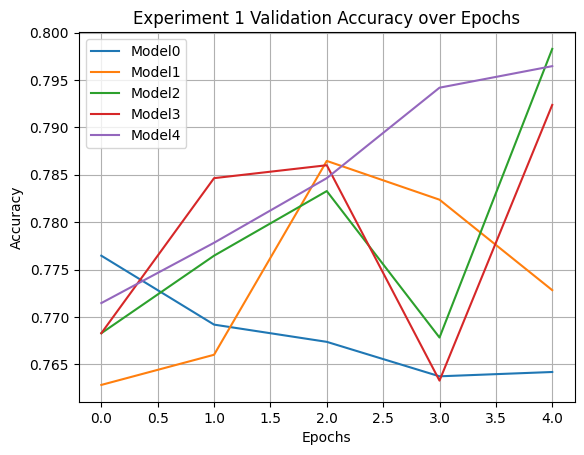

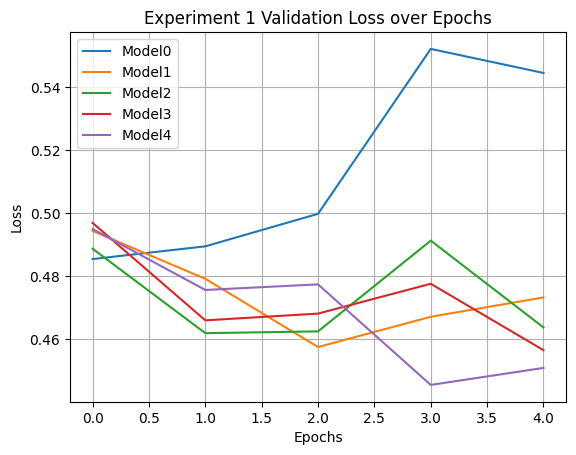

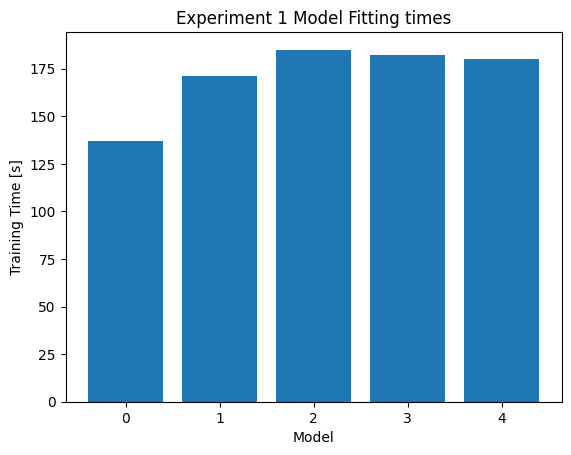

In [134]:
perform_basic_plots(1, exp1_histories, exp1_times)

From Experiment 1, we can see that Models 0 and 1 were inferior to the rest of the models. Model 4 seemed to be the best, which corresponded with the most repeating layers of [Conv2D, MaxPool]. This makes sense because the model is more complex and can interpret more advanced image features. Interestingly there was no significant increase in training time for the later models in this experiment.

## Experiment 2: Changing the amount of Conv2D layers
For this experiement the idea is to try different numbers of [Conv2D] layers before a couple max pools to close out the model.

In [135]:
exp_2_n = 5

experiment_2_models = []

for i in range(5):
    new_model = Sequential()
    new_model.add(Conv2D(32, (3,3), activation = 'relu', input_shape=(96,96,3)))

    for j in range(i):
        new_model.add(Conv2D(32, (3,3), activation = 'relu'))
    
    new_model.add(MaxPooling2D(pool_size=(2,2)))
    new_model.add(MaxPooling2D(pool_size=(2,2)))

    new_model.add(Flatten())
    new_model.add(Dense(128, activation='relu'))
    new_model.add(Dense(1, activation='sigmoid')) 

    custom_optimizer = Adam(
        learning_rate = .001,
    )
    new_model.compile(optimizer = custom_optimizer,
                    loss = 'binary_crossentropy',
                    metrics = ['accuracy'])

    experiment_2_models.append(new_model)

In [136]:
exp2_histories, exp2_times = perform_experiment(
    experiment_2_models,
    train_generator,
    test_generator,
    num_epochs=5)

Started Timer
Epoch 1/5
275/275 [==============================] - 23s 82ms/step - loss: 0.5507 - accuracy: 0.7308 - val_loss: 0.6252 - val_accuracy: 0.6897
Epoch 2/5
275/275 [==============================] - 23s 82ms/step - loss: 0.4806 - accuracy: 0.7785 - val_loss: 0.4706 - val_accuracy: 0.7833
Epoch 3/5
275/275 [==============================] - 22s 80ms/step - loss: 0.4655 - accuracy: 0.7875 - val_loss: 0.4907 - val_accuracy: 0.7628
Epoch 4/5
275/275 [==============================] - 22s 80ms/step - loss: 0.4446 - accuracy: 0.7964 - val_loss: 0.4882 - val_accuracy: 0.7606
Epoch 5/5
275/275 [==============================] - 23s 82ms/step - loss: 0.4247 - accuracy: 0.8094 - val_loss: 0.4791 - val_accuracy: 0.7810
Stopped Timer
Time on the clock : 112
Started Timer
Epoch 1/5
275/275 [==============================] - 72s 261ms/step - loss: 0.6211 - accuracy: 0.6120 - val_loss: 0.6283 - val_accuracy: 0.6011
Epoch 2/5
275/275 [==============================] - 72s 260ms/step - loss:

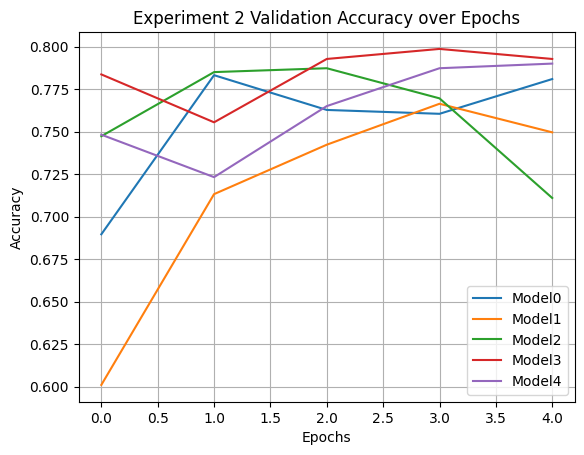

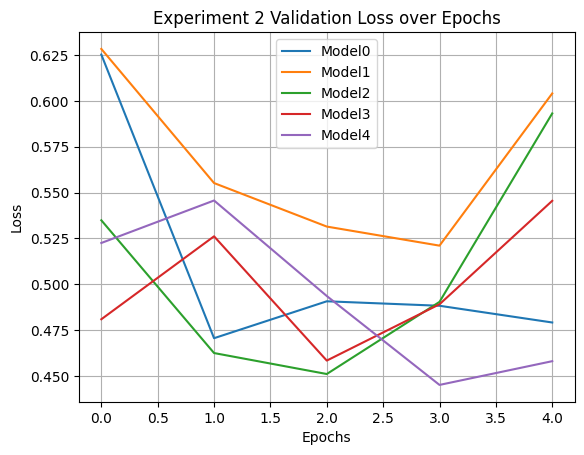

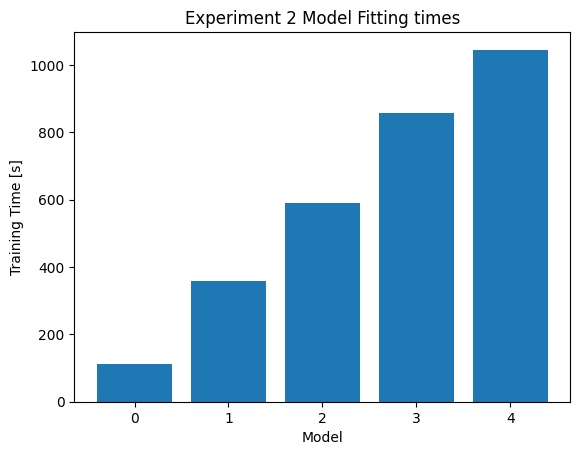

In [138]:
perform_basic_plots(2, exp2_histories, exp2_times)

In Experiment 2, we can see that Model 4 performed the best in the case of Loss and Model 3 performed the best in the case of Accuracy. Models 3 and 4 correspond with 4x and 5x layers of Conv2D in our model. The trade off is that with each layer of Conv2D added to the model, the training time significantly increases. It makes sense that the training time increases with every Conv2D layer because Conv2D layers each have a large number of parameters to train and adjust. Based on this, Model 3 was selected to be used as a basis for our final model and 4x Conv2D layers will be used.

## Experiment 3: Changing the amount of  MaxPool layers

For this experiement the idea is to try different numbers of [MaxPool] layers. To start the model, 2x [Conv2D] layers are used to kick off the model and the MaxPools come after this.

In [139]:
exp_3_n = 5
experiment_3_models = []

for i in range(exp_3_n):
    new_model = Sequential()
    new_model.add(Conv2D(32, (3,3), activation = 'relu', input_shape=(96,96,3)))
    new_model.add(Conv2D(32, (3,3), activation = 'relu'))

    for j in range(i):
        new_model.add(MaxPooling2D(pool_size=(2,2)))

    new_model.add(Flatten())
    new_model.add(Dense(128, activation='relu'))
    new_model.add(Dense(1, activation='sigmoid')) 

    custom_optimizer = Adam(
        learning_rate = .001,
    )
    new_model.compile(optimizer = custom_optimizer,
                    loss = 'binary_crossentropy',
                    metrics = ['accuracy'])

    experiment_3_models.append(new_model)

In [140]:
exp3_histories, exp3_times = perform_experiment(
    experiment_3_models,
    train_generator,
    test_generator,
    num_epochs=5)

Started Timer
Epoch 1/5
275/275 [==============================] - 105s 379ms/step - loss: 0.9222 - accuracy: 0.6036 - val_loss: 0.6342 - val_accuracy: 0.5697
Epoch 2/5
275/275 [==============================] - 105s 381ms/step - loss: 0.5888 - accuracy: 0.6400 - val_loss: 0.6735 - val_accuracy: 0.6184
Epoch 3/5
275/275 [==============================] - 101s 367ms/step - loss: 0.4788 - accuracy: 0.7924 - val_loss: 0.7100 - val_accuracy: 0.6356
Epoch 4/5
275/275 [==============================] - 100s 364ms/step - loss: 0.2633 - accuracy: 0.9074 - val_loss: 0.9315 - val_accuracy: 0.6529
Epoch 5/5
275/275 [==============================] - 101s 368ms/step - loss: 0.0990 - accuracy: 0.9722 - val_loss: 1.3052 - val_accuracy: 0.6152
Stopped Timer
Time on the clock : 511
Started Timer
Epoch 1/5
275/275 [==============================] - 78s 280ms/step - loss: 0.6084 - accuracy: 0.7102 - val_loss: 0.4896 - val_accuracy: 0.7660
Epoch 2/5
275/275 [==============================] - 77s 279ms/st

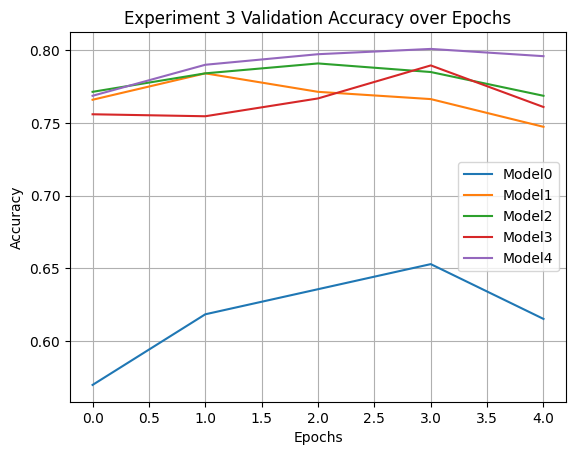

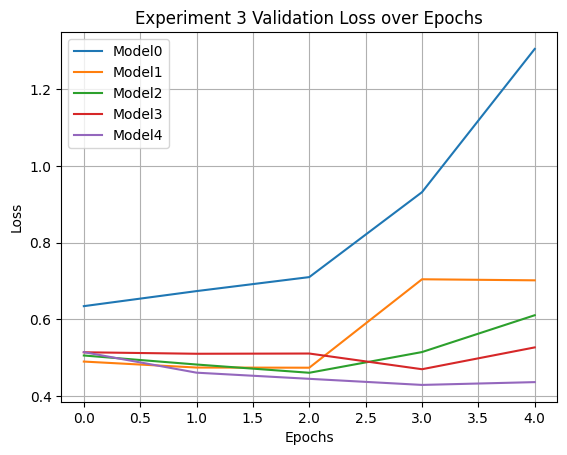

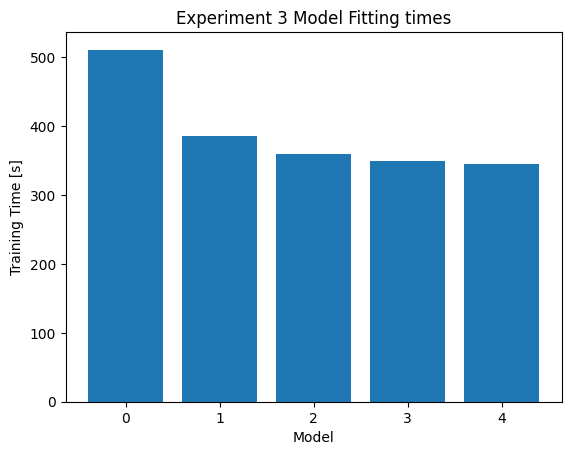

In [141]:
perform_basic_plots(3, exp3_histories, exp3_times)

From Experiment 3, we can see that Model 4 was the best performing Model. In this experiment, Model 4 represents 4 MaxPool Layers after 2x Conv2D layers. Not only did it have the best performing trends on the Loss and Accuracy plots, it also had the fastest training time. This makes sense why more MaxPools result in a faster training time as the more the image data is reduced, the less parameters need to exist in the model. From this, we will use 4x MaxPool layers in our final model.

## Experiment 4: Changing the Learning Rate

For this experiment, a few selections for learning rate will be tried and the performance will be assessed. The best learning rate will be selected from this set to form the final model.

In [142]:
exp4_learning_rates = [.01, .005, .001, .0005, .0001]

experiment_4_models = []

for learning_rate in exp4_learning_rates:
    new_model = Sequential()
    new_model.add(Conv2D(32, (3,3), activation = 'relu', input_shape=(96,96,3)))
    new_model.add(MaxPooling2D(pool_size=(2,2)))

    new_model.add(Flatten())
    new_model.add(Dense(128, activation='relu'))
    new_model.add(Dense(1, activation='sigmoid')) 

    custom_optimizer = Adam(
        learning_rate = learning_rate,
    )
    
    new_model.compile(optimizer = custom_optimizer,
                    loss = 'binary_crossentropy',
                    metrics = ['accuracy'])

    experiment_4_models.append(new_model)

In [143]:
exp4_histories, exp4_times = perform_experiment(
    experiment_4_models,
    train_generator,
    test_generator,
    num_epochs=5)

Started Timer
Epoch 1/5
275/275 [==============================] - 28s 100ms/step - loss: 1.6186 - accuracy: 0.6014 - val_loss: 0.6859 - val_accuracy: 0.5697
Epoch 2/5
275/275 [==============================] - 27s 99ms/step - loss: 0.6716 - accuracy: 0.6064 - val_loss: 0.6845 - val_accuracy: 0.5697
Epoch 3/5
275/275 [==============================] - 27s 97ms/step - loss: 0.6712 - accuracy: 0.6064 - val_loss: 0.6879 - val_accuracy: 0.5697
Epoch 4/5
275/275 [==============================] - 27s 98ms/step - loss: 0.6706 - accuracy: 0.6064 - val_loss: 0.6860 - val_accuracy: 0.5697
Epoch 5/5
275/275 [==============================] - 27s 97ms/step - loss: 0.6710 - accuracy: 0.6064 - val_loss: 0.6885 - val_accuracy: 0.5697
Stopped Timer
Time on the clock : 135
Started Timer
Epoch 1/5
275/275 [==============================] - 27s 98ms/step - loss: 1.0482 - accuracy: 0.6037 - val_loss: 0.6547 - val_accuracy: 0.5697
Epoch 2/5
275/275 [==============================] - 27s 96ms/step - loss: 

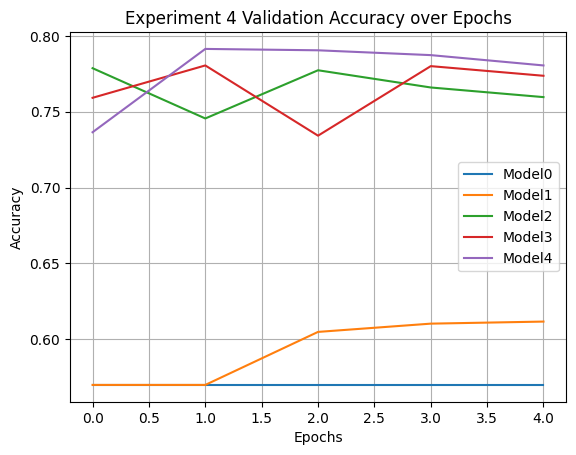

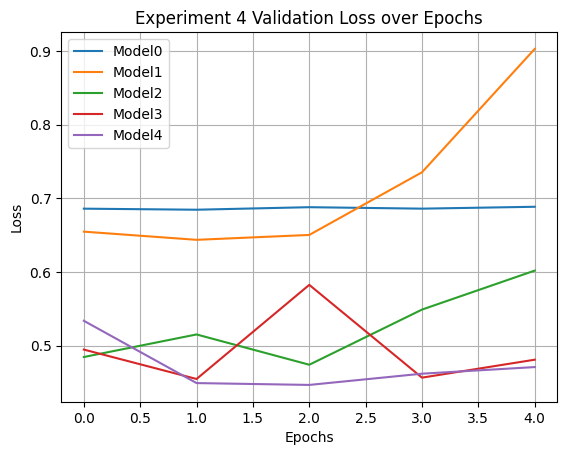

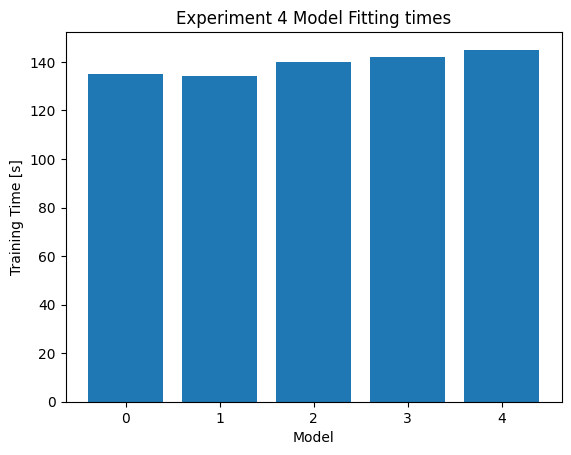

In [145]:
perform_basic_plots(4, exp4_histories, exp4_times)

From the Experiment 4 Training, we can see that Model 4 was the best performing Model. Model 4 corresponds with a training rate of 0.0001. With only a slight increase in training time, this learning rate improved the validation accuracy and the loss function on this dataset. This learning rate will be selected for the final model.

## Final Model

Conclusions from Experiments and Hyperparameter Tuning:

From Experiment 1: More [Conv2D, MaxPool] pairs results in better performance, with little cost in training time

From Experiment 2: More Conv2D layers results in higher training time and better performance

From Experiment 3: More MaxPool layers results in lower training time and better performance

From Experiment 4: A training rate of 0.0001 should be used

So for the Final Model we should build something with:
- At Least 4 Max Pool layers
- More than 3 Conv2D layers but less than 5 to avoid extreme training times
- A Learning Rate of 0.0001

Ok, now that we have run our experiments, it is time to build and train the full model. 

Lets start by getting the full data in order to train our model on:

In [122]:
full_X = train_df.drop(columns = ["id", "label"])
full_y = train_df.drop(columns = ["id", "filepath"])

# Create the Train Test split on our subset for training and validation data
full_X_train, full_X_test, full_y_train, full_y_test = train_test_split(full_X, full_y, test_size= .2, random_state=42)

# Reformat into dataframes for the generators
full_train_data_df = full_X_train.copy()
full_train_data_df["label"] = full_y_train["label"]

full_test_data_df = full_X_test.copy()
full_test_data_df["label"] = full_y_test["label"]

# Start the Image Data Generators to load files fast
# # Scale all values to 1
datagen = ImageDataGenerator(rescale=1./255)

full_train_generator = datagen.flow_from_dataframe(
    dataframe = full_train_data_df,
    x_col = 'filepath',
    y_col = 'label',
    target_size = (96,96),
    batch_size = 32,
    class_mode = 'binary',
)
full_test_generator = datagen.flow_from_dataframe(
    dataframe = full_test_data_df,
    x_col = 'filepath',
    y_col = 'label',
    target_size = (96,96),
    batch_size = 32,
    class_mode = 'binary',
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


Alright, now we are ready to build our model

In [150]:
full_model = Sequential()
full_model.add(Conv2D(32, (3,3), activation = 'relu', input_shape=(96,96,3)))
full_model.add(Conv2D(48, (3,3), activation = 'relu'))
full_model.add(MaxPooling2D(pool_size=(2,2)))

full_model.add(Conv2D(64, (3,3), activation = 'relu'))
full_model.add(Conv2D(80, (3,3), activation = 'relu'))
full_model.add(MaxPooling2D(pool_size=(2,2)))
full_model.add(MaxPooling2D(pool_size=(2,2)))
full_model.add(MaxPooling2D(pool_size=(2,2)))

full_model.add(Flatten())
full_model.add(Dense(128, activation='relu'))
full_model.add(Dense(1, activation='sigmoid')) 

custom_optimizer = Adam(
    learning_rate = .0001,
)
full_model.compile(optimizer = custom_optimizer,
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

Now we can train the model on the full data

In [151]:
num_epochs = 10

history = full_model.fit(
            full_train_generator,
            epochs = num_epochs,
            validation_data = full_test_generator,
        )

Epoch 1/10
5501/5501 [==============================] - 3311s 602ms/step - loss: 0.4245 - accuracy: 0.8062 - val_loss: 0.3473 - val_accuracy: 0.8482
Epoch 2/10
5501/5501 [==============================] - 3214s 584ms/step - loss: 0.3299 - accuracy: 0.8577 - val_loss: 0.3032 - val_accuracy: 0.8711
Epoch 3/10
5501/5501 [==============================] - 2809s 511ms/step - loss: 0.2867 - accuracy: 0.8795 - val_loss: 0.2572 - val_accuracy: 0.8921
Epoch 4/10
5501/5501 [==============================] - 2692s 489ms/step - loss: 0.2561 - accuracy: 0.8945 - val_loss: 0.2521 - val_accuracy: 0.8953
Epoch 5/10
5501/5501 [==============================] - 2883s 524ms/step - loss: 0.2333 - accuracy: 0.9055 - val_loss: 0.2795 - val_accuracy: 0.8821
Epoch 6/10
5501/5501 [==============================] - 2696s 490ms/step - loss: 0.2159 - accuracy: 0.9133 - val_loss: 0.2071 - val_accuracy: 0.9199
Epoch 7/10
5501/5501 [==============================] - 2700s 491ms/step - loss: 0.1998 - accuracy: 0.9207

## Results And Analysis

ADDRESSING RUBRIC: Please see the above experiments and summaries following thier graphs for "...hyperparameter tuning, apply techniques to improve training or performance, and discuss what helped"

Ok lets go ahead and see how our final model performed:

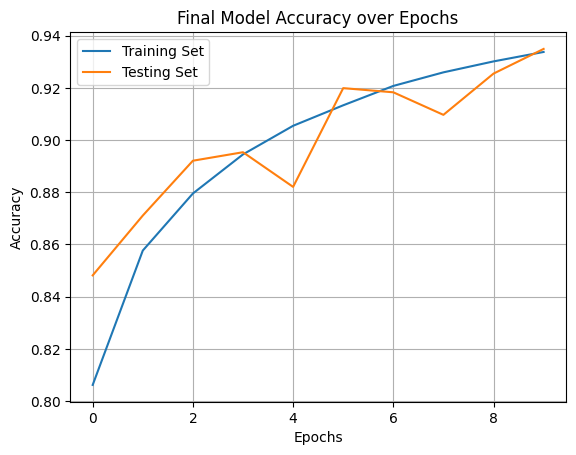

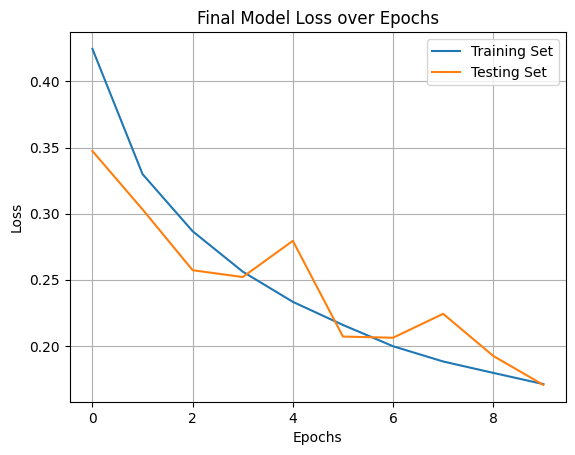

In [152]:
legend = ["Training Set", "Testing Set"]

# Plot the Accuracy
plt.plot(history.epoch, history.history["accuracy"])
plt.plot(history.epoch, history.history["val_accuracy"])
plt.title(f"Final Model Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(legend)
plt.grid()
plt.show()

# Plot the Loss
plt.plot(history.epoch, history.history["loss"])
plt.plot(history.epoch, history.history["val_loss"])
plt.title(f"Final Model Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(legend)
plt.grid()
plt.show()

## Conclusion

In this project various model architectures were explored and compared as well as some hyperparameter tuning to form an educated guess on the best type of model to choose to classify this data set. In order to save time the data was signficantly truncated so that  many variations in model architectures could be tried. 

In total, 4 explicit experiments were conducted in order to gain insight on how to build the best model. These experiments were as follows
- Changing the amount of [Conv2D, Maxpool] layers present in the model
- Changing the amount of [Conv2D] layers present in the model
- Changing the amount of [MaxPool] layers present in the model
- Changing the learning rate of the model

From these experiments, educated decisions were made about the best architecture and hyperparameters to use and this was trained on the full set of data, with a small set split off for validation purposes.

### Interpretation of Results and Takeaways

From the Final Model Loss and Accuracy Plots, it can be seen that the model performs very well and the learning rate is appropriate for this data. It can also be seen that the Training and Test curves do not diverge, which would indicate overfitting. If anything, the curves represent underfitting as it looks like with more epochs, even more performance could be extracted from this model.

### What helped and what did not help

It seems that the experiments conducted for this project really helped to select a good model. However, in hindsight, Experiment 1 was not as useful as the others. It did not make sense to have multiple pairs of [Conv2D, MaxPool] in the final model architecture. Also, Experiment 4 was especially useful as it indicated a more appropriate learning rate than would have otherwise been used if this was left as default.

In addition, using a small subset of data to iterate on the models and perform the experiment was very useful as it saved a ton of time and allowed for more iteration than would have otherwise been possible due to developer time constraints.

### What could be done differently next time
- Check to see the effects of different depths in the Conv2D layers had on the model
- Compare the effectiveness of Max pooling versus Average Pooling
- Perform Analysis on the optimal number of epochs

In [ ]:
# Generate the Submission File for Kaggle

submission_datagen = ImageDataGenerator(rescale=1./255)

testing_image_paths = [str(img) for img in testing_images]
df = pd.DataFrame(
    {'img_paths': testing_image_paths}
)

submission_generator = submission_datagen.flow_from_dataframe(
    dataframe = df,
    x_col = 'img_paths',
    target_size = (96, 96),
    batch_size = 32,
    shuffle = False,
    class_mode = None,
)

predictions = full_model.predict(submission_generator)

ids = [Path(f).stem for f in submission_generator.filenames]
predictions_list = [round(float(i)) for i in predictions]

submission_df = pd.DataFrame(
    {'id': ids, 'label': predictions_list}
    )

submission_df.to_csv('submission.csv', index=False)